In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

TASK = 'cpg_methylation'
MODEL = 'hyenadna-tiny-1k'

bt_dir = '../results/BaseTrainer'
onthefly_dir = '../results/BatchOnTheFly'

In [11]:
def get_results_dfs(results_dir, task, model):

    losses_path = os.path.join(results_dir, task, model, 'losses.csv')
    losses_df = pd.read_csv(losses_path)
    
    val_auroc_df = losses_df.loc[:, ['Epoch', 'val_auroc']]
    
    losses_df = pd.melt(losses_df.loc[:,losses_df.columns!='val_auroc'], id_vars='Epoch', var_name='Split', value_name='BCE Loss')

    results_path = os.path.join(results_dir, task, model, 'best_model_metrics.csv')
    results_df = pd.read_csv(results_path)
    
    return losses_df, val_auroc_df, results_df


bt_losses, bt_val_auroc, bt_results = get_results_dfs(bt_dir, TASK, MODEL)
onthefly_losses, onthefly_val_auroc, onthefly_results = get_results_dfs(onthefly_dir, TASK, MODEL)

In [14]:
print(f"BaseTrainer - {TASK} mean AUROC: {bt_results['test_auroc_avg'].iloc[0]}")
print(f"OnTheFly - {TASK} mean AUROC: {onthefly_results['test_auroc_avg'].iloc[0]}")

BaseTrainer - cpg_methylation mean AUROC: 0.8422637958429171
OnTheFly - cpg_methylation mean AUROC: 0.9033952871782356


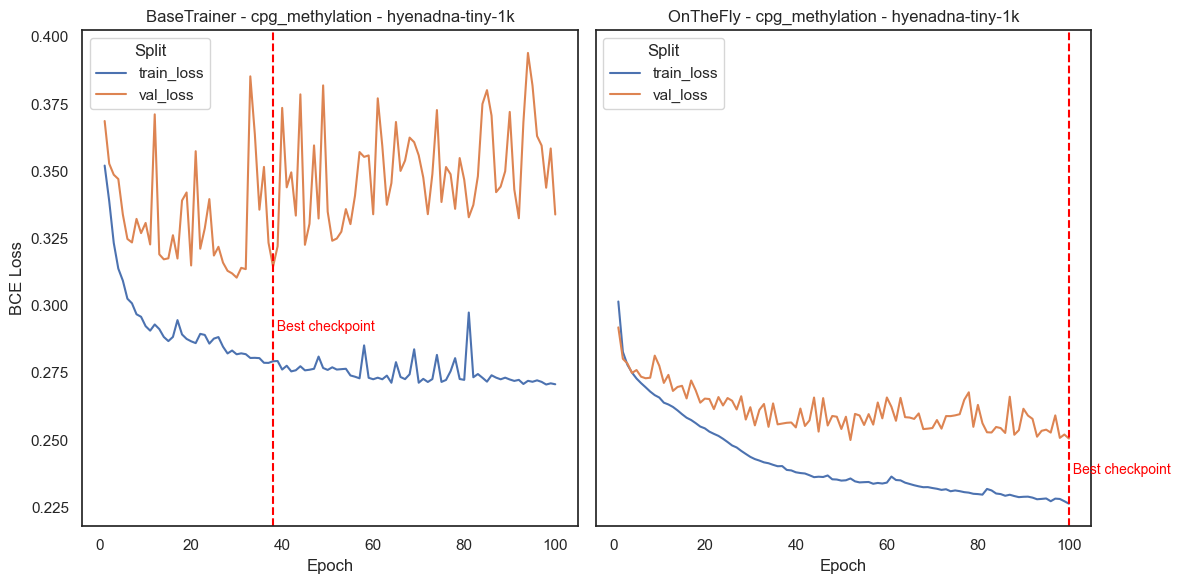

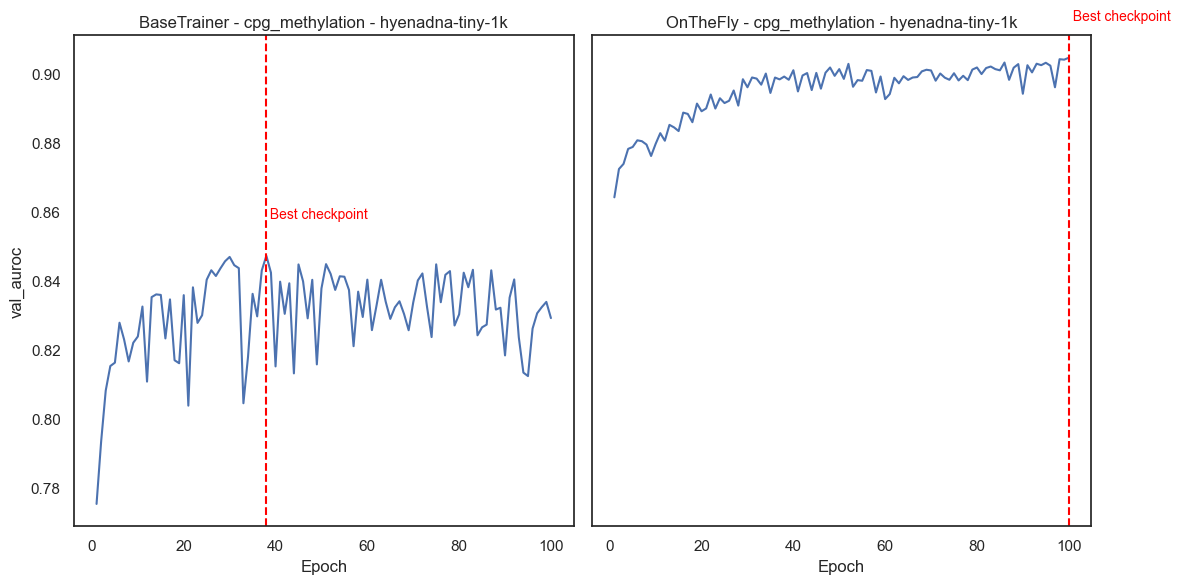

In [38]:
def print_checkpoint(ax, results_df, value_col='train_loss'):
    ax.axvline(x=results_df['Epoch'][0], color='red', linestyle='--', linewidth=1.5)
    ax.text(results_df['Epoch'][0], results_df[value_col][0]+.01, ' Best checkpoint', 
            horizontalalignment='left', verticalalignment='bottom', color='red', fontsize=10)

sns.set_theme(style="white")

fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharex=True, sharey=True)
sns.lineplot(data=bt_losses, x='Epoch', y='BCE Loss', hue='Split', ax=ax[0])
sns.lineplot(data=onthefly_losses, x='Epoch', y='BCE Loss', hue='Split', ax=ax[1])
ax[0].set_title(f'BaseTrainer - {TASK} - {MODEL}')
print_checkpoint(ax[0], bt_results)
ax[1].set_title(f'OnTheFly - {TASK} - {MODEL}')
print_checkpoint(ax[1], onthefly_results)
plt.tight_layout()

fig, ax = plt.subplots(ncols=2, figsize=(12,6),sharex=True, sharey=True)
sns.lineplot(data=bt_val_auroc, x='Epoch', y='val_auroc', ax=ax[0])
sns.lineplot(data=onthefly_val_auroc, x='Epoch', y='val_auroc', ax=ax[1])
ax[0].set_title(f'BaseTrainer - {TASK} - {MODEL}')
print_checkpoint(ax[0], bt_results, value_col='val_auroc')
ax[1].set_title(f'OnTheFly - {TASK} - {MODEL}')
print_checkpoint(ax[1], onthefly_results, value_col='val_auroc')
plt.tight_layout()
